In [1]:
library(liana)
library(Seurat)
library(tibble)
library(purrr)
library(gprofiler2)
library(tidyverse)
library(SummarizedExperiment)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tidyr     1.3.0
✔ lubridate 1.9.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [24]:
options(repr.plot.width = 18, repr.plot.height = 17, repr.plot.pointsize = 24)

In [2]:
op_resource <- select_resource("OmniPath")[[1]]

In [3]:
genes <- union(op_resource$source_genesymbol, op_resource$target_genesymbol)

In [4]:
genes_convert <- gorth(query = genes, source_organism = "hsapiens", target_organism = "sscrofa")

In [5]:
genes_convert <- genes_convert[!duplicated(genes_convert$input_number),]

In [6]:
op_resource <- op_resource %>%
        left_join(genes_convert, by=c("target_genesymbol"="input")) %>%
        mutate(target_genesymbol = ortholog_name, .keep = "unused") %>%
        left_join(genes_convert, by=c("source_genesymbol"="input")) %>%
        mutate(source_genesymbol = ortholog_name, .keep = "unused") %>%
        filter(!is.na(target_genesymbol) | !is.na(source_genesymbol)) %>%
        filter(!is.na(target_genesymbol)) %>%
        filter(!is.na(source_genesymbol))

In [7]:
load(file = "/home/adufour/work/rds_storage/omics/stem_cells_seurat.Rdata")

In [ ]:
liana_test <- liana_wrap(seurat.integrated,
                         method = c("sca", "natmi", "logfc", "connectome", "call_italk", "call_connectome"),
                         resource = "custom",
                         external_resource = op_resource)

In [14]:
liana_test %>% glimpse

List of 6
 $ sca            : tibble [24,513 × 12] (S3: tbl_df/tbl/data.frame)
  ..$ source          : chr [1:24513] "C2" "C2" "C2" "C2" ...
  ..$ target          : chr [1:24513] "C2" "C2" "C2" "C2" ...
  ..$ ligand.complex  : chr [1:24513] "PRNP" "BMPR1B" "CHL1" "PTPRT" ...
  ..$ ligand          : chr [1:24513] "PRNP" "BMPR1B" "CHL1" "PTPRT" ...
  ..$ receptor.complex: chr [1:24513] "NCAM1" "BMPR2" "TMEM132A" "CDH1" ...
  ..$ receptor        : chr [1:24513] "NCAM1" "BMPR2" "TMEM132A" "CDH1" ...
  ..$ receptor.prop   : num [1:24513] 0.253 0.909 0.461 0.97 0.23 ...
  ..$ ligand.prop     : num [1:24513] 0.176 0.531 0.228 0.215 0.128 ...
  ..$ ligand.expr     : num [1:24513] 0.136 0.991 0.282 0.244 0.096 ...
  ..$ receptor.expr   : num [1:24513] 0.343 4.024 0.465 8.066 0.196 ...
  ..$ global_mean     : num [1:24513] 0.312 0.312 0.312 0.312 0.312 ...
  ..$ LRscore         : num [1:24513] 0.409 0.865 0.537 0.818 0.306 ...
 $ natmi          : tibble [24,513 × 14] (S3: tbl_df/tbl/data.frame)


In [15]:
liana_result <- liana_test %>% liana_aggregate() %>% as.data.frame()

Warning message in exec(output, ...):
“Using internal and external methods should be done with caution!”
Now aggregating sca

Now aggregating natmi

Now aggregating logfc

Now aggregating connectome

Now aggregating call_italk

Now aggregating call_connectome

Aggregating Ranks



In [17]:
saveRDS(liana_result, file = "/home/adufour/work/rds_storage/LR/liana/liana_multiomics.rds")

In [18]:
library(tidyverse)
library(liana)
library(nichenetr)
library(Seurat)
library(ggrepel)
library(cowplot)


Attachement du package : ‘cowplot’


L'objet suivant est masqué depuis ‘package:lubridate’:

    stamp




In [21]:
# filter results to cell types of interest
C4_C2_results <- liana_result %>%
  subset(source == "C4" & target == "C2")

In [22]:
# filter results to top N interactions
n <- 50
top_n_C4_C2 <- C4_C2_results %>%
  arrange(aggregate_rank) %>%
  slice_head(n = n) %>%
  mutate(id = fct_inorder(paste0(ligand, " -> ", receptor)))

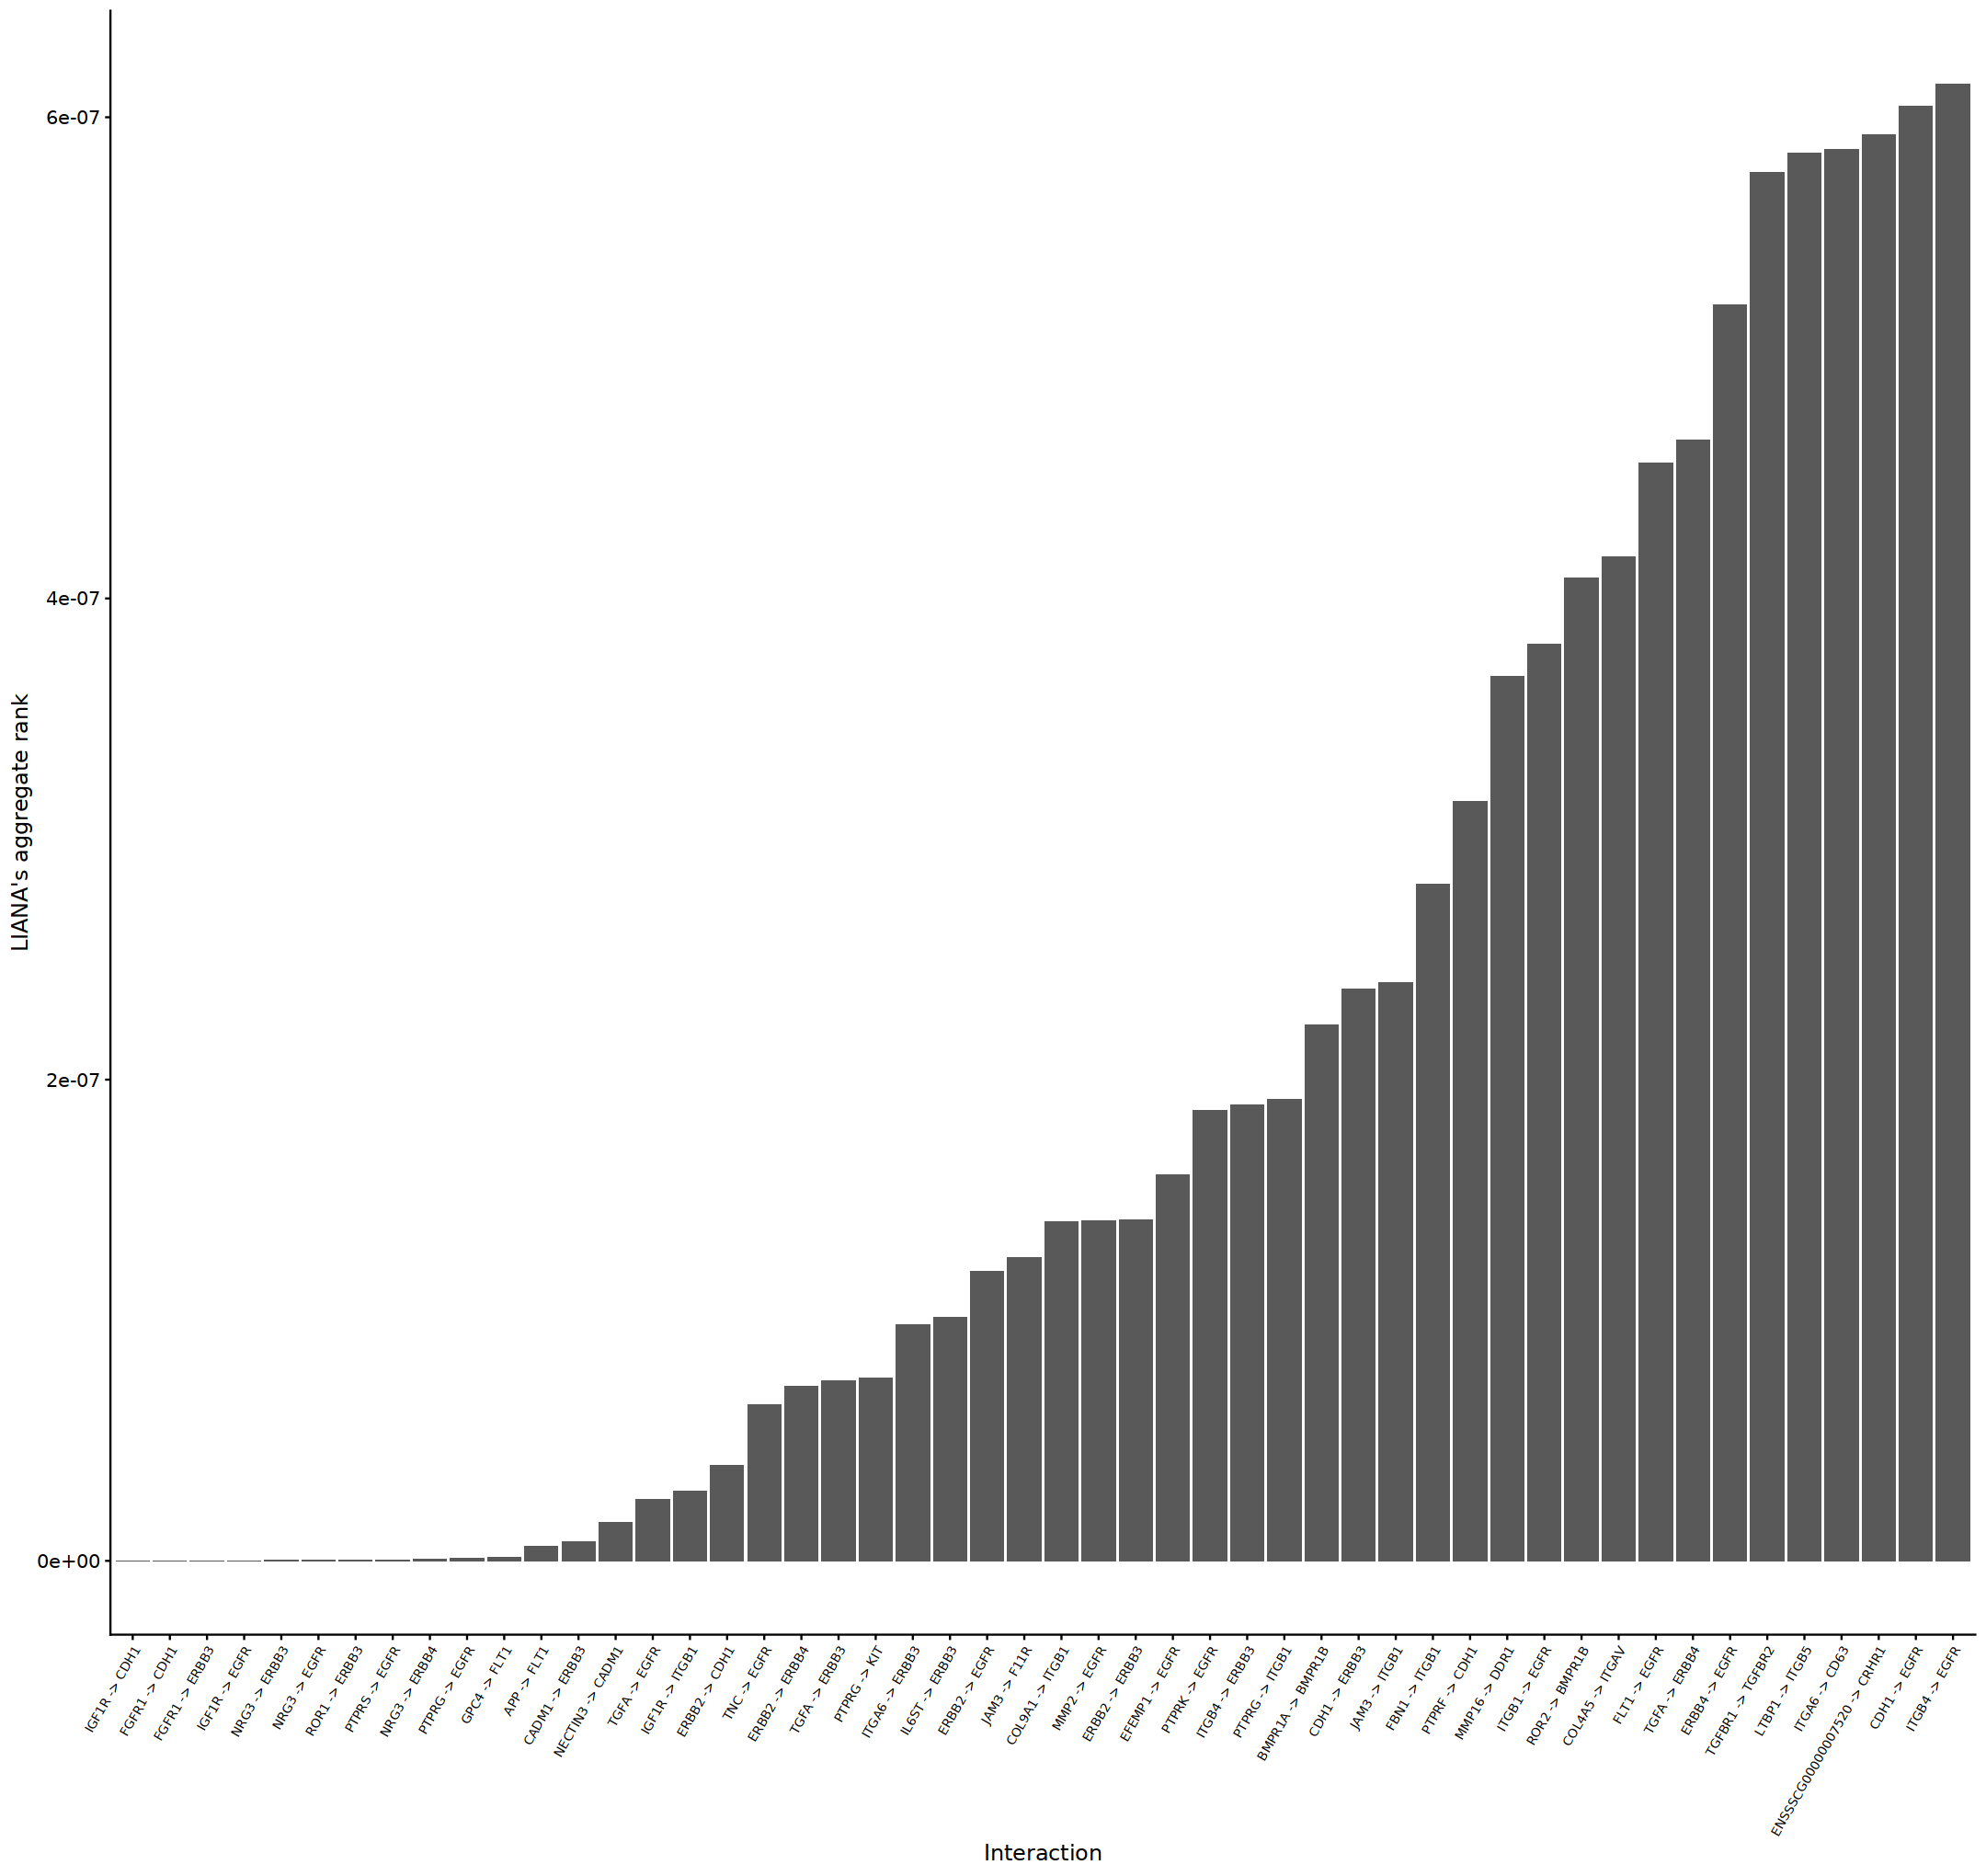

In [25]:
# visualize median rank
top_n_C4_C2 %>%
  ggplot(aes(y = aggregate_rank, x = id)) +
  geom_bar(stat = "identity") +
  xlab("Interaction") + ylab("LIANA's aggregate rank") +
  theme_cowplot() +
  theme(axis.text.x = element_text(size = 8, angle = 60, hjust = 1, vjust = 1))

In [27]:
ligand_target_matrix = readRDS(url("https://zenodo.org/record/7074291/files/ligand_target_matrix_nsga2r_final.rds"))

In [ ]:
# get ligands and filter to those included in NicheNet's ligand-target matrix
ligands <- c(unique(top_n_C4_C2$ligand), "GNAS")
ligands <- ligands[ligands %in% colnames(ligand_target_matrix)]

In [42]:
expression <- embryo.data
sample_info <- embryo_obj@meta.data
colnames(sample_info) <- make.names(colnames(sample_info))

In [48]:
sample_info <- sample_info %>%
  subset(Clusters %in% c("C2", "C4"))

In [50]:
sample_info$cell <- rownames(sample_info)

In [53]:
expression <- expression[,sample_info$cell ]

In [54]:
expression <- t(expression)

In [57]:
background_genes <- expression[sample_info$cell[sample_info$Clusters == "C4"], ] %>%
  apply(2,function(x){10*(2**x - 1)}) %>%
  apply(2,function(x){log2(mean(x) + 1)}) %>%
  .[. >= 4] %>%
  names()

In [58]:
geneset_oi <- read_tsv(url("https://zenodo.org/record/3260758/files/pemt_signature.txt"), col_types = cols(), col_names = "gene") %>%
  pull(gene) %>%
  .[. %in% rownames(ligand_target_matrix)]

In [63]:
DE_table_receiver = FindMarkers(object = embryo_obj, ident.1 = "C2", ident.2 = "C4", min.pct = 0.10) %>% rownames_to_column("gene")

geneset_oi = DE_table_receiver %>% filter(p_val_adj <= 0.05 & abs(avg_log2FC) >= 0.25) %>% pull(gene)
geneset_oi = geneset_oi %>% .[. %in% rownames(ligand_target_matrix)]

In [65]:
nichenet_activities <- predict_ligand_activities(
  geneset = geneset_oi,
  background_expressed_genes = background_genes,
  ligand_target_matrix = ligand_target_matrix, potential_ligands = ligands
)

In [66]:
# prepare data for visualization
vis_liana_nichenet <- top_n_C4_C2 %>%
  inner_join(nichenet_activities, by = c("ligand" = "test_ligand")) %>%
  arrange(pearson) %>%
  mutate(ligand = fct_inorder(ligand))

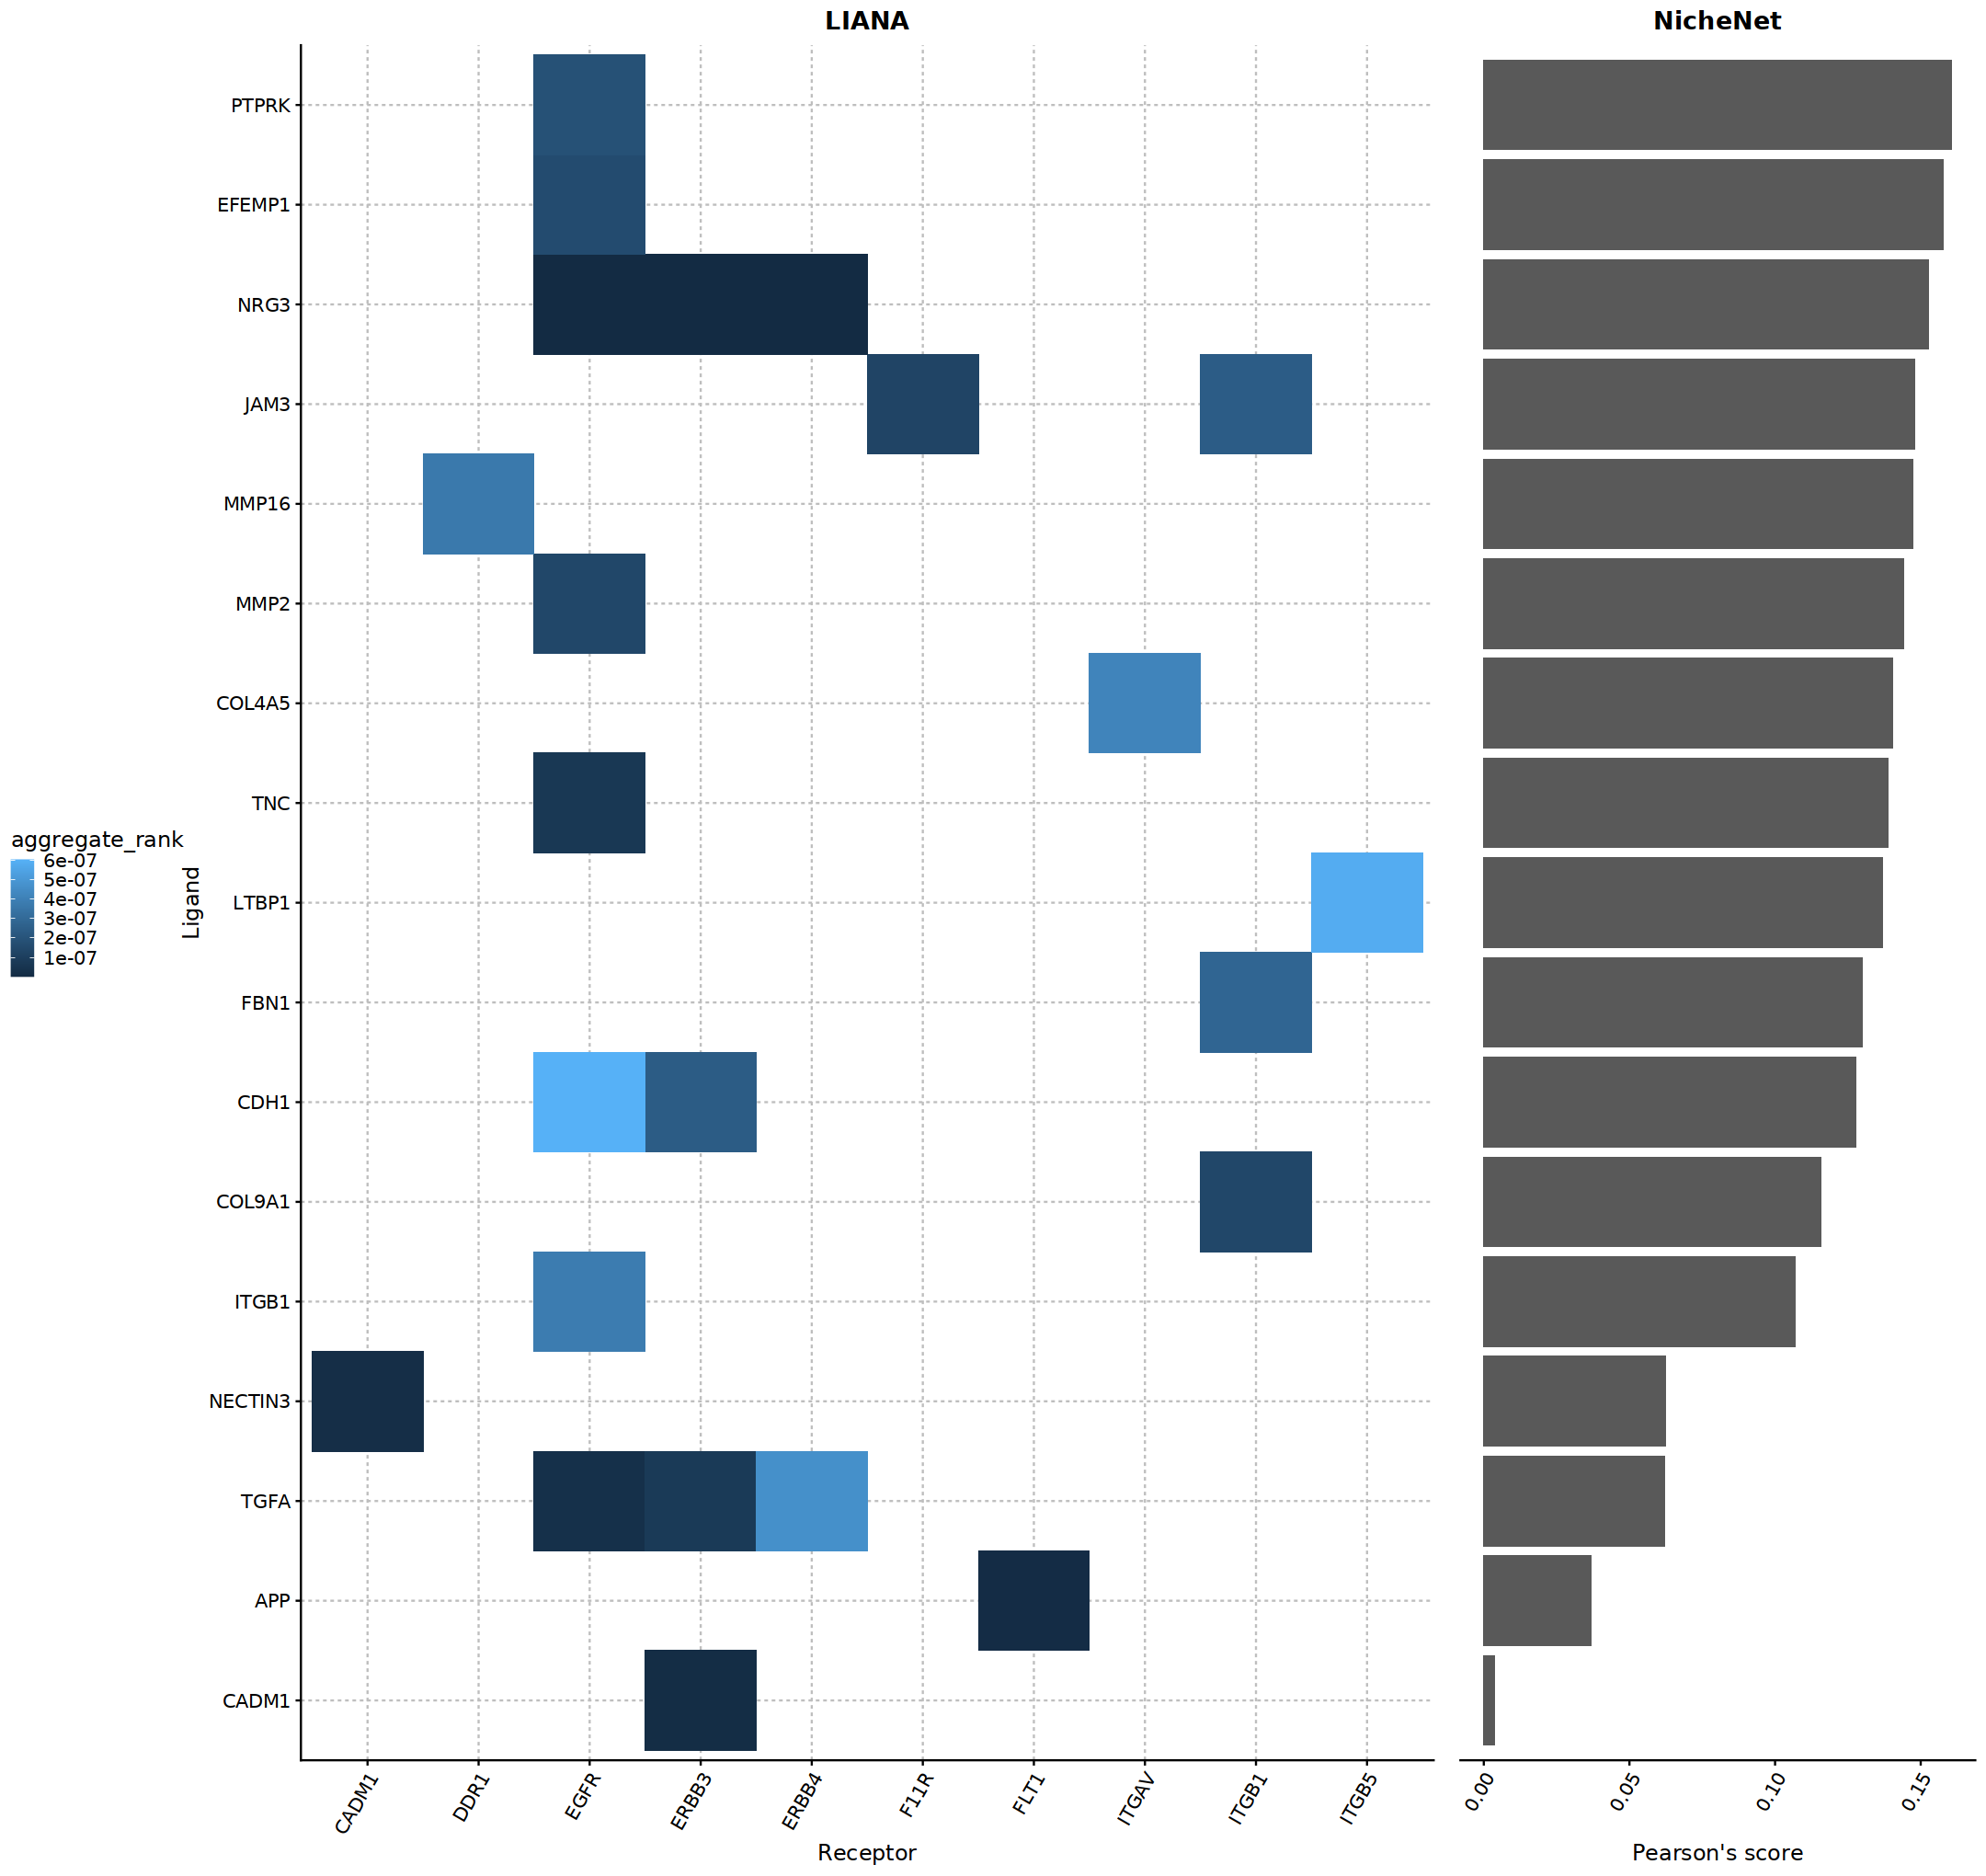

In [67]:
# prepare NicheNet figure
nichenet_scores_plot <- vis_liana_nichenet %>%
  group_by(ligand) %>%
  summarize(pearson = mean(pearson)) %>%
  ggplot(aes(y = ligand, x = pearson)) +
  geom_bar(stat = "identity") +
  ggtitle("NicheNet") +
  xlab("Pearson's score") +
  theme_cowplot() +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        axis.line.y = element_line(color = "white"),
        plot.title = element_text(hjust = 0.5),
        axis.text.x = element_text(angle = 60, hjust = 1, vjust = 1))

# prepare LIANA figure
liana_receptor_heatmap <- vis_liana_nichenet %>%
  ggplot(aes(y = ligand, x = receptor, fill = aggregate_rank)) +
  geom_tile() +
  theme_cowplot() +
  ggtitle("LIANA") +
  ylab("Ligand") + xlab("Receptor") +
  theme(axis.text.x = element_text(angle = 60, hjust = 1, vjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid.major = element_line(colour = "gray", linetype = 2),
        legend.position = "left")

# combine plots
plot_grid(liana_receptor_heatmap, nichenet_scores_plot,
          align = "h", nrow = 1, rel_widths = c(0.8,0.3))